Import Libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression

Load Datasets

In [20]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (1460, 81)
Test shape: (1459, 80)


Visualize Target Variable Distribution

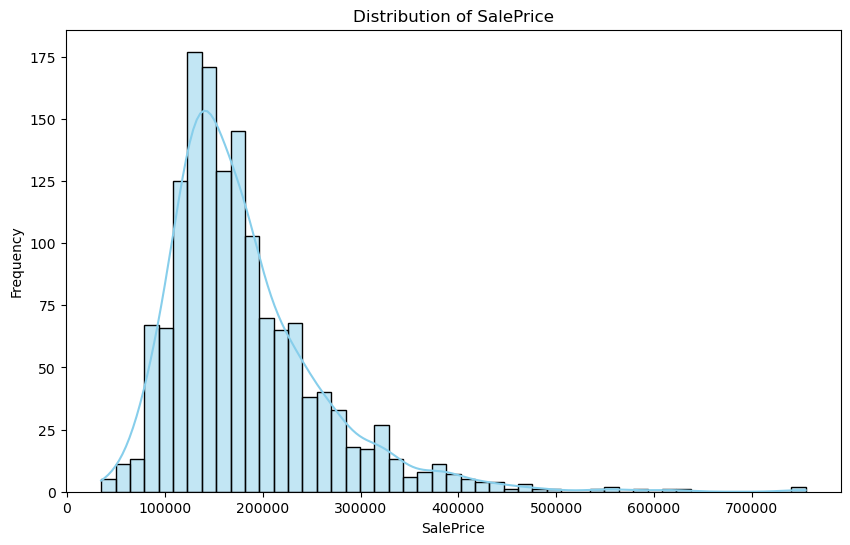

In [21]:
plt.figure(figsize=(10,6))
sns.histplot(train['SalePrice'], kde=True, color="skyblue")
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

Correlation Heatmap of Top Features

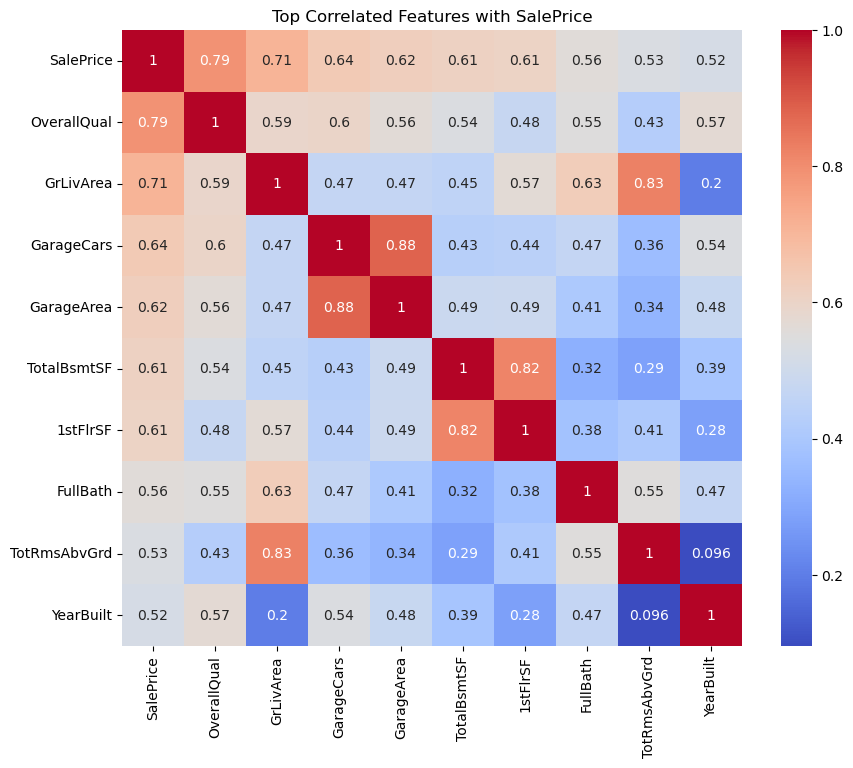

In [22]:
numeric_train = train.select_dtypes(include=[np.number])
corrmat = numeric_train.corr()
top_corr_features = corrmat['SalePrice'].sort_values(ascending=False).head(10).index

plt.figure(figsize=(10, 8))
sns.heatmap(train[top_corr_features].corr(), annot=True, cmap='coolwarm')
plt.title("Top Correlated Features with SalePrice")
plt.show()

Combine Train and Test Data

In [23]:
train_ID = train['Id']
test_ID = test['Id']
y = train['SalePrice']
y_log = np.log1p(y)

train.drop(['SalePrice'], axis=1, inplace=True)
all_data = pd.concat([train, test], axis=0, sort=False)
all_data.drop(['Id'], axis=1, inplace=True)

Missing Data Heatmap

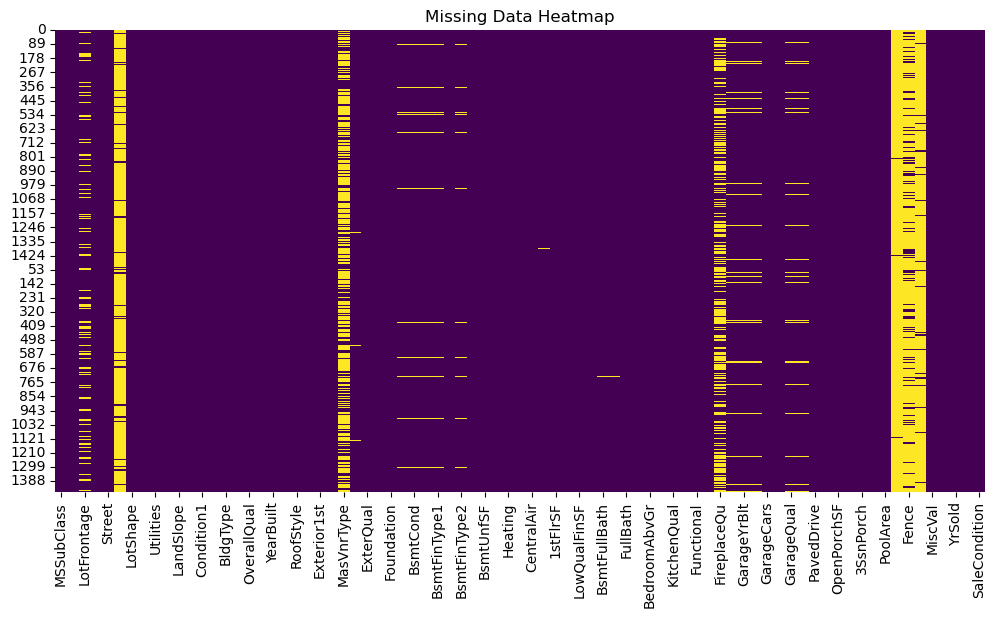

In [24]:
plt.figure(figsize=(12, 6))
sns.heatmap(all_data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

Impute Missing Values

In [25]:
for col in all_data.columns:
    if all_data[col].dtype == "object":
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    else:
        all_data[col] = all_data[col].fillna(all_data[col].median())


Label Encoding for Ordinal Features

In [26]:
ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'HeatingQC', 'KitchenQual', 'FireplaceQu',
                'GarageQual', 'GarageCond', 'PoolQC']

for col in ordinal_cols:
    lbl = LabelEncoder()
    all_data[col] = lbl.fit_transform(all_data[col])

One-Hot Encoding

In [27]:
all_data = pd.get_dummies(all_data)
print("Shape after one-hot encoding:", all_data.shape)

Shape after one-hot encoding: (2919, 253)


Feature Engineering

In [28]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBathrooms'] = all_data['FullBath'] + (0.5 * all_data['HalfBath']) + all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath'])
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['RemodAge'] = all_data['YrSold'] - all_data['YearRemodAdd']
all_data['GarageAge'] = all_data['YrSold'] - all_data['GarageYrBlt']


 Remove Outliers

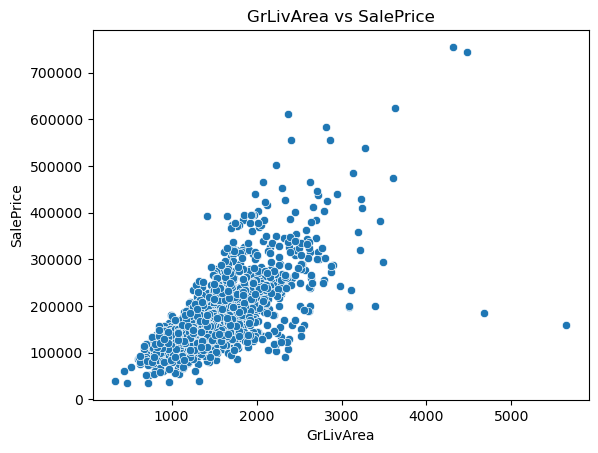

In [29]:
sns.scatterplot(x=train['GrLivArea'], y=y)
plt.title("GrLivArea vs SalePrice")
plt.show()

outlier_idx = train[(train['GrLivArea'] > 4500) & (y > 300000)].index
X_train = all_data[:len(y)].drop(index=outlier_idx)
y_log = y_log.drop(index=outlier_idx)
X_test = all_data[len(y):]

 Feature Scaling

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Model Evaluation Function

In [31]:
def rmse_cv(model, X, y):
    kf = KFold(5, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse.mean()

Base Model Training

In [32]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_log)

gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_log)

GradientBoostingRegressor(random_state=42)

Evaluate Base Models

In [33]:
print("RF CV RMSE:", rmse_cv(rf, X_train, y_log))
print("GB CV RMSE:", rmse_cv(gb, X_train, y_log))


RF CV RMSE: 0.14258522248098918
GB CV RMSE: 0.1329387457414125


Stacking Ensemble (RF + GB)

In [34]:
stack_model = StackingRegressor(
    estimators=[
        ('rf', rf),
        ('gb', gb)
    ],
    final_estimator=LinearRegression(),
    cv=5
)

stack_model.fit(X_train_scaled, y_log)
stack_preds_log = stack_model.predict(X_test_scaled)
stack_preds_final = np.expm1(stack_preds_log)

Feature Importance (Random Forest)

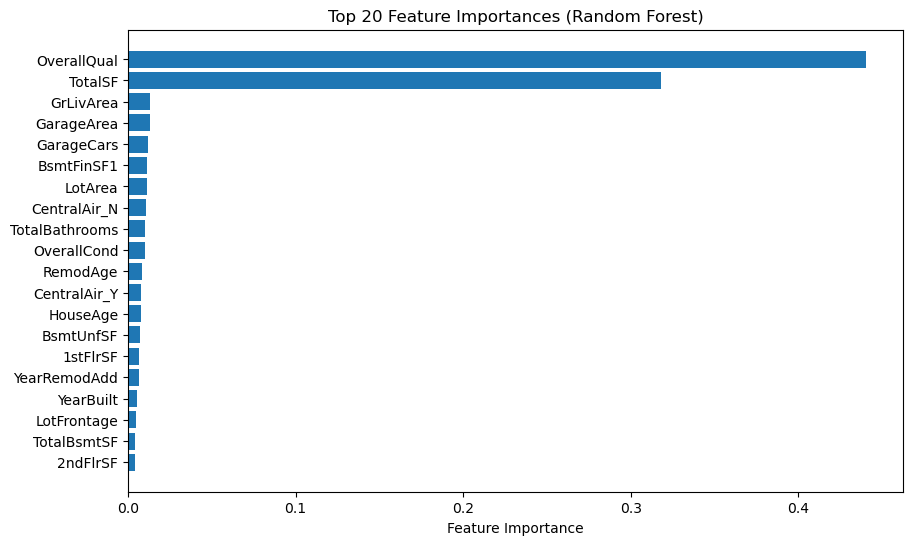

In [35]:
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]
features = X_train.columns[indices]

plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances (Random Forest)")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features)
plt.xlabel("Feature Importance")
plt.show()

Submission (Using Stacking Model)

In [36]:
submission = pd.DataFrame({
    'Id': test_ID,
    'SalePrice': stack_preds_final
})
submission.to_csv("predictions.csv", index=False)
print("Submission saved to predictions.csv")

Submission saved to predictions.csv
